## import

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Input, Merge, Conv2D, MaxPooling2D, UpSampling2D,Convolution2D,Dropout,merge
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
tbCallBack = keras.callbacks.TensorBoard(log_dir='/mnt/tensorboard',\
                                         histogram_freq=0, write_graph=True, write_images=True)
from keras_tqdm import TQDMNotebookCallback
callbacks = [TQDMNotebookCallback(leave_inner=True),tbCallBack]
#from data import load_train_data, load_test_data

## generate

In [3]:
def add_rect(a):
    try:
        half_size = np.random.choice(canvas_size//4)+10
        cx, cy = [np.random.choice(canvas_size-40)+20,np.random.choice(canvas_size-40)+20] # The center of rect
        y, x = np.ogrid[-half_size: half_size, -half_size: half_size]
        a[cy-half_size:cy+half_size, cx-half_size:cx+half_size] = 255
        return a
    except:
        return a

In [4]:
def add_cicle(a):
    try:
        radius = np.random.choice(canvas_size//4)+10
        cx, cy = [np.random.choice(canvas_size-40)+20,np.random.choice(canvas_size-40)+20] # The center of circle
        y, x = np.ogrid[-radius: radius, -radius: radius]
        index = x**2 + y**2 <= radius**2
        a[cy-radius:cy+radius, cx-radius:cx+radius][index] = 255

        return a
    except:
        return a

In [5]:
def add_tri(a):
    try:
        sizer=np.random.choice(canvas_size//4)+10
        y, x = np.ogrid[-sizer: sizer, -sizer: sizer]
        index = x + y >0
        cx, cy = [np.random.choice(canvas_size-40)+20,np.random.choice(canvas_size-40)+20]#[np.random.choice(canvas_size-50)+25,np.random.choice(canvas_size-50)+25]

        a[cy-sizer:cy+sizer, cx-sizer:cx+sizer][index] = 255

        return a
    except:
        return a

In [6]:
dataset=[]
%time
import warnings
warnings.filterwarnings('ignore')
for i in range(10000):
   
    canvas_size=96

    #draw circle
    a = np.zeros((canvas_size, canvas_size)).astype('uint8')
    circle=add_cicle(a)

    a = np.zeros((canvas_size, canvas_size)).astype('uint8')
    rect=add_rect(a)
    
    a = np.zeros((canvas_size, canvas_size)).astype('uint8')
    tri=add_tri(a)

    #comvine
    final=circle.copy()
    if np.sum(final+rect)==np.sum(final)+np.sum(rect):
        final+=rect
    else:
        rect=np.zeros((canvas_size, canvas_size)).astype('uint8')
    if np.sum(final+tri)==np.sum(final)+np.sum(tri):
        final+=tri
    else:
        tri=np.zeros((canvas_size, canvas_size)).astype('uint8')
        
    dataset.append([final,circle,rect,tri])
    
dataset=np.expand_dims(np.array(dataset),-1)/255
#plt.imshow(dataset[:,0,:,:,0]) - the final images
#plt.imshow(dataset[i,1,:,:,0]) - the circel images
#plt.imshow(dataset[i,2,:,:,0]) - the rect images
#plt.imshow(dataset[i,3,:,:,0]) - the triangke images

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


In [8]:
np.save('/mnt/kaggle_ultrasound/saved/uveye_shapes_data_set.npy', dataset)

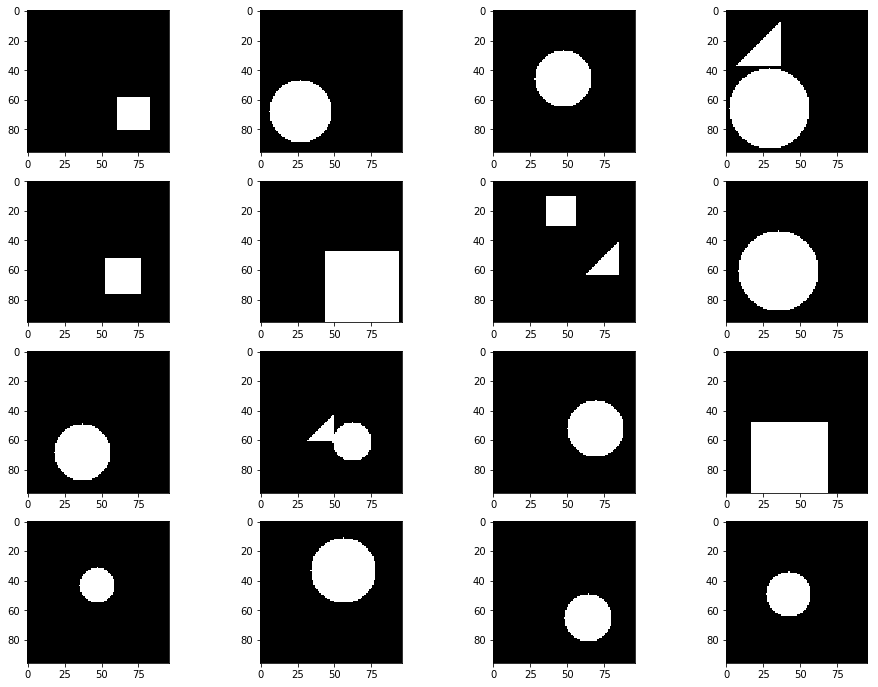

In [120]:
#show some samples
fig = plt.figure(figsize=(16,12))

for i,id in enumerate(np.random.choice(10000,16)):
    ax = fig.add_subplot(4,4,i+1)
    plt.grid(False)
    plt.imshow(dataset[id,0,:,:,0],cmap='gray')

## preprocess

In [544]:
trn,val,trn_out,val_out=train_test_split(dataset[:,0,:,:,:],dataset[:,1,:,:,:])

In [606]:
model_circle.fit(trn,trn_out,nb_epoch=30, batch_size=64,callbacks=callbacks,verbose=0,validation_data=(val,val_out))

## unets

unet was not used eventualy

In [55]:

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def diff_loss(y_true, y_pred):
    #L! dist
    return K.sum(K.abs(K.flatten(y_true)-K.flatten(y_pred)))

In [56]:
#mini unet
def get_mini_unet():
    inputs = Input((img_rows, img_cols,1))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(p)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(p)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(p)(conv3)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    up8 = merge([UpSampling2D(size=(2, 2))(conv3), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(p)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(p)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    mini_model = Model(input=inputs, output=conv10)

    mini_model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=['mean_squared_error'])
    return mini_model

In [57]:
#
def add_block(inp,filters=32,p=0.2,type='down',bridge_layer=''):#'bottom','up'
    if type=='up':
        inp = merge([UpSampling2D(size=(2, 2))(inp), bridge_layer], mode='concat', concat_axis=3)
    conv = Convolution2D(filters, 3, 3, activation='relu', border_mode='same')(inp)
    conv = Dropout(p)(conv)
    conv = Convolution2D(filters, 3, 3, activation='relu', border_mode='same')(conv)
    if type=='bottom':
        return conv
    else:
        return MaxPooling2D(pool_size=(2, 2))(conv)

In [354]:
p=0
inputs = Input((img_rows, img_cols,1))
conv1=add_block(inputs,32)
conv2=add_block(conv1,64)
conv3=add_block(conv2,128)
conv4=add_block(conv3,256)
conv5=add_block(conv4,512,type='bottom')
conv6=add_block(conv5,256,type='up',bridge_layer=conv4)
conv7=add_block(conv6,128,type='up',bridge_layer=conv3)
conv8=add_block(conv7,64,type='up',bridge_layer=conv2)
conv9=add_block(conv7,32,type='up',bridge_layer=conv1)
conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

model = Model(input=inputs, output=conv10)

model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef_loss])

ValueError: "concat" mode can only merge layers with matching output shapes except for the concat axis. Layer shapes: [(None, 12, 12, 512), (None, 6, 6, 256)]

In [83]:
#unet
def get_unet(p=0.0): #p is the dropout rate
    
    inputs = Input((96, 96,1))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(p)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(p)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(p)(conv3)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(p)(conv4)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(p)(conv5)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(p)(conv6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(p)(conv7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(p)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(p)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef_loss])
    return model

In [84]:
unet=get_unet()

In [64]:
trn_out.shape

(4226, 96, 96, 1)

In [93]:
unet.fit(trn,trn_out,validation_data=(val,val_out),nb_epoch=20, batch_size=64,callbacks=callbacks,shuffle=True,\
         verbose=0)

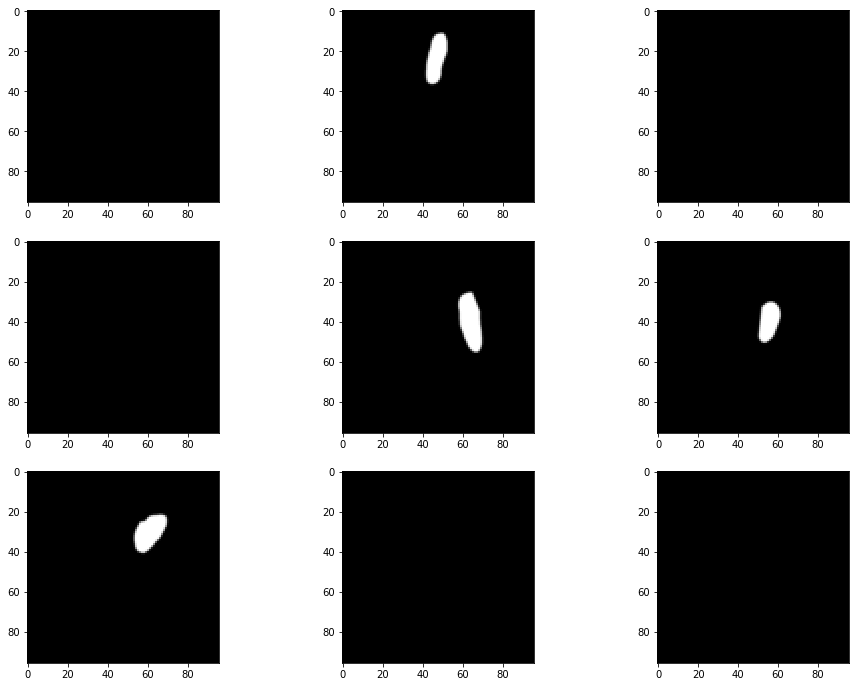

In [94]:
#examine prediction
fig = plt.figure(figsize=(16,12))
preds=[]
for i,id in enumerate(np.random.choice(2000,9)):
    ax = fig.add_subplot(3,3,i+1)
    plt.grid(False)
    pred=unet.predict(val[i:i+1])
    pred = np.argmax(pred, axis=-1)
    pred= pred.reshape((-1,96,96))
    preds.append(pred) 
    plt.imshow(trn_out[i:i+1][0,:,:,0],cmap='gray')

In [95]:
np.unique(preds)

array([0])

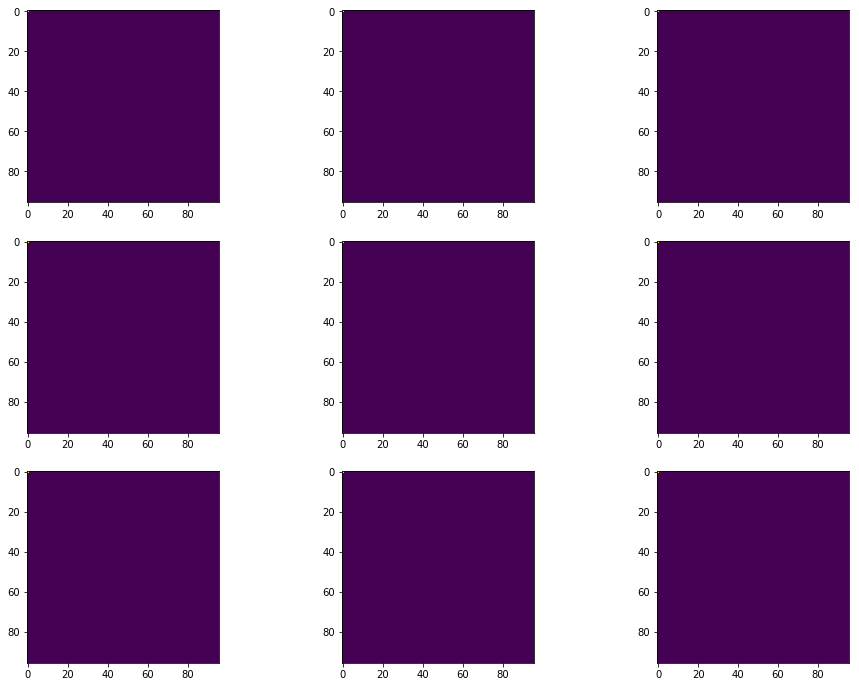

In [89]:
fig = plt.figure(figsize=(16,12))

for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    plt.grid(False)
    preds[i][0][0,0]=3
    plt.imshow(preds[i][0])

## Tiramisu

In [3]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [4]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [5]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [6]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [7]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [8]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [9]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

In [10]:
def reverse(a): return list(reversed(a))

In [11]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

In [12]:
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
    
limit_mem()

In [13]:
input_shape = (96,96,1)

In [14]:
from keras.layers import *
import random
img_input = Input(shape=input_shape)

In [15]:
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Model, Sequential
import threading

In [21]:
img_input = Input(shape=input_shape)

In [24]:
x = create_tiramisu(12, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [50]:
model = Model(img_input, x)
#is there is an error, run again from x

In [27]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [28]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(96,96), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.rows, self.cols = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.rows)
        slice_c = self.get_slice(self.ci, self.cols)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

In [29]:
dataset=np.load('/mnt/kaggle_ultrasound/saved/uveye_shapes_data_set.npy')

In [30]:
#convert data to segmentation format
inp=dataset[:,0,:,:,:]
out=dataset[:,1,:,:,:]+dataset[:,2,:,:,:]*2+dataset[:,3,:,:,:]*3
trn,val,trn_out,val_out=train_test_split(inp,out)

In [31]:
gen_train = segm_generator(trn, trn_out, 3, train=True)
gen_test = segm_generator(val, val_out, 3, train=False)

In [32]:
b_img, b_label = next(gen_train)

In [33]:
b_img.shape,b_label.shape

((3, 96, 96, 1), (3, 9216, 1))

In [34]:
1+1

2

In [51]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [ ]:
rnd_trn = len(trn_labels)

In [37]:
len(trn)

7500

In [38]:
history=model.fit_generator(gen_train,1000,nb_epoch=100, verbose=1, 
                    #callbacks=callbacks,
                            validation_data=gen_test,
                            nb_val_samples=len(val)
                           )

Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.0787 - acc: 0.9937

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1002/1000 [==============================] - 242s - loss: 0.0787 - acc: 0.9937 - val_loss: 0.0583 - val_acc: 0.9989
Epoch 2/100
1002/1000 [==============================] - 241s - loss: 0.0634 - acc: 0.9952 - val_loss: 0.0467 - val_acc: 0.9979
Epoch 3/100
  63/1000 [>.............................] - ETA: 112s - loss: 0.0603 - acc: 0.9947

KeyboardInterrupt: 

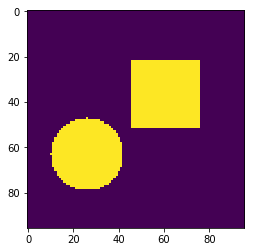

In [175]:
#examine prediction
i=45
pred=model.predict(val[i:i+1])
pred = np.argmax(pred, axis=-1)
pred = pred.reshape((-1,96,96))
plt.imshow(val[i:i+1][0,:,:,0],cmap='gray')

2


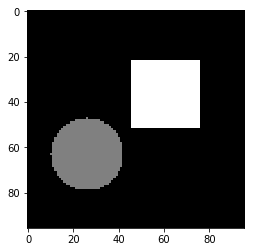

In [176]:
print(np.max(pred[0]))
plt.imshow(pred[0],cmap='gray')

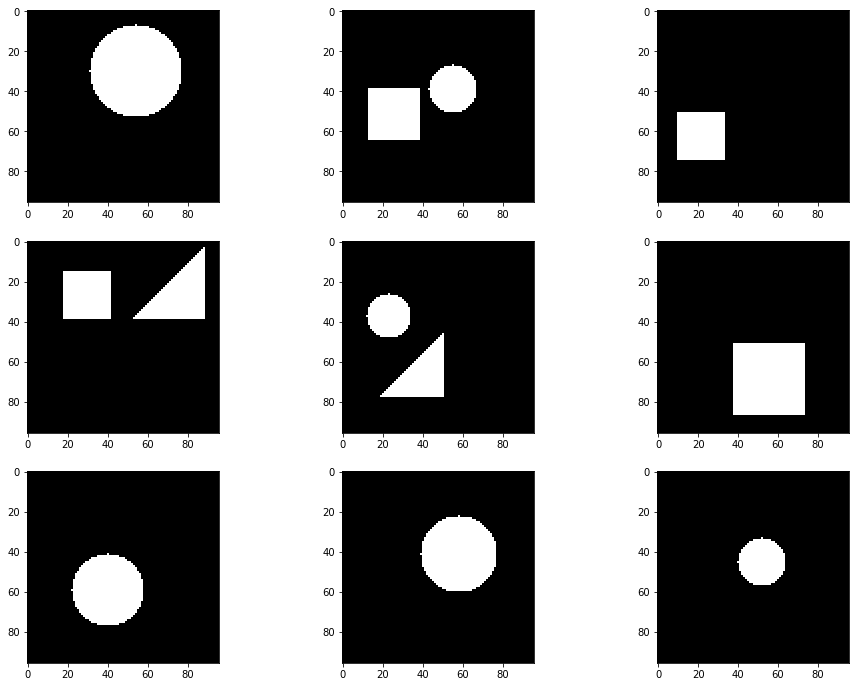

In [39]:
#examine prediction
fig = plt.figure(figsize=(16,12))
preds=[]
for i,id in enumerate(np.random.choice(2000,9)):
    ax = fig.add_subplot(3,3,i+1)
    plt.grid(False)
    pred=model.predict(val[i:i+1])
    pred = np.argmax(pred, axis=-1)
    pred= pred.reshape((-1,96,96))
    preds.append(pred) 
    plt.imshow(val[i:i+1][0,:,:,0],cmap='gray')

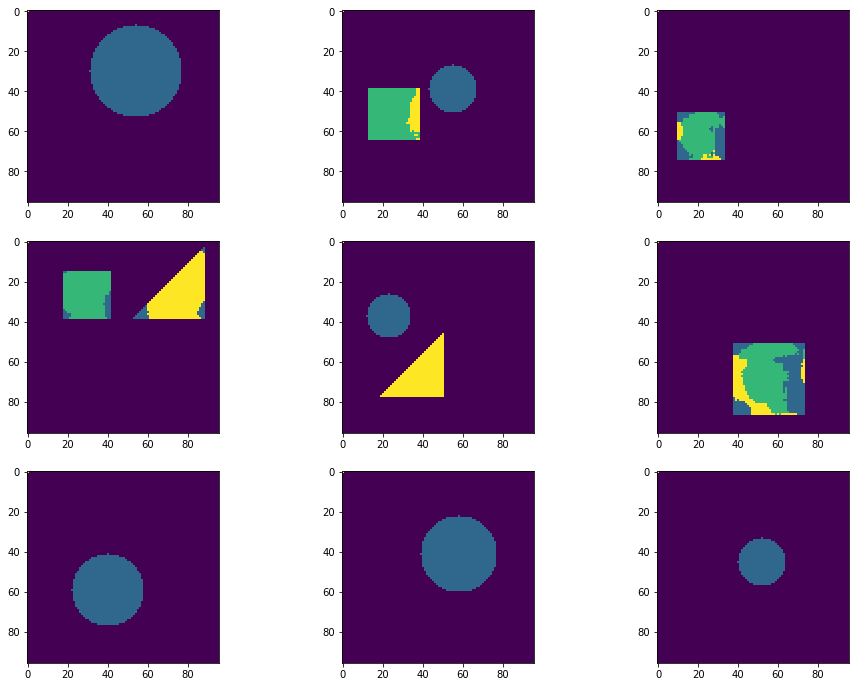

In [40]:
fig = plt.figure(figsize=(16,12))

for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    plt.grid(False)
    preds[i][0][0,0]=3
    plt.imshow(preds[i][0])

## add from ultrasound, delete later

In [41]:
def load_train_data():
    imgs_train = np.load('/mnt/kaggle_ultrasound/saved/imgs_train.npy')
    imgs_mask_train = np.load('/mnt/kaggle_ultrasound/saved/imgs_mask_train.npy')
    return imgs_train, imgs_mask_train

In [42]:
train=load_train_data()

In [45]:
from scipy.misc import imresize
size=[96,96]
X=[]
y=[]
for image in train[0]:
    X.append(imresize(image,(size[0],size[1])))
    
for image in train[1]:
    y.append(imresize(image,(size[0],size[1])))
    
X=np.array(X)
y=np.array(y)

In [46]:
X=np.expand_dims(X,-1)
y=np.expand_dims(y,-1)

In [47]:
y=y/255
X=X/255

In [48]:
trn,val,trn_out,val_out=train_test_split(X,y)

In [49]:
gen_train = segm_generator(trn, trn_out, 3, train=True)
gen_test = segm_generator(val, val_out, 3, train=False)

In [52]:
history=model.fit_generator(gen_train, 1000,nb_epoch=100, verbose=1, 
                    #callbacks=callbacks,
                            validation_data=gen_test, nb_val_samples=100
                           )

Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 0.0983 - acc: 0.9821

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1002/1000 [==============================] - 135s - loss: 0.0982 - acc: 0.9821 - val_loss: 0.0944 - val_acc: 0.9861
Epoch 2/100
1002/1000 [==============================] - 126s - loss: 0.0591 - acc: 0.9848 - val_loss: 0.0498 - val_acc: 0.9857
Epoch 3/100
 357/1000 [=========>....................] - ETA: 77s - loss: 0.0490 - acc: 0.9870

KeyboardInterrupt: 

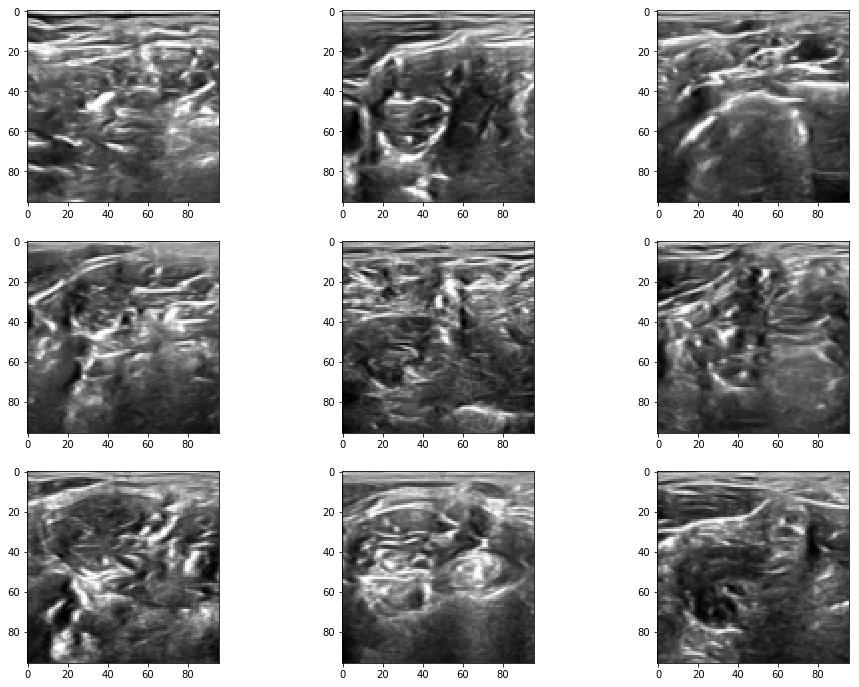

In [53]:
#examine prediction
fig = plt.figure(figsize=(16,12))
preds=[]
for i,id in enumerate(np.random.choice(2000,9)):
    ax = fig.add_subplot(3,3,i+1)
    plt.grid(False)
    pred=model.predict(val[i:i+1])
    pred = np.argmax(pred, axis=-1)
    pred= pred.reshape((-1,96,96))
    preds.append(pred) 
    plt.imshow(val[i:i+1][0,:,:,0],cmap='gray')

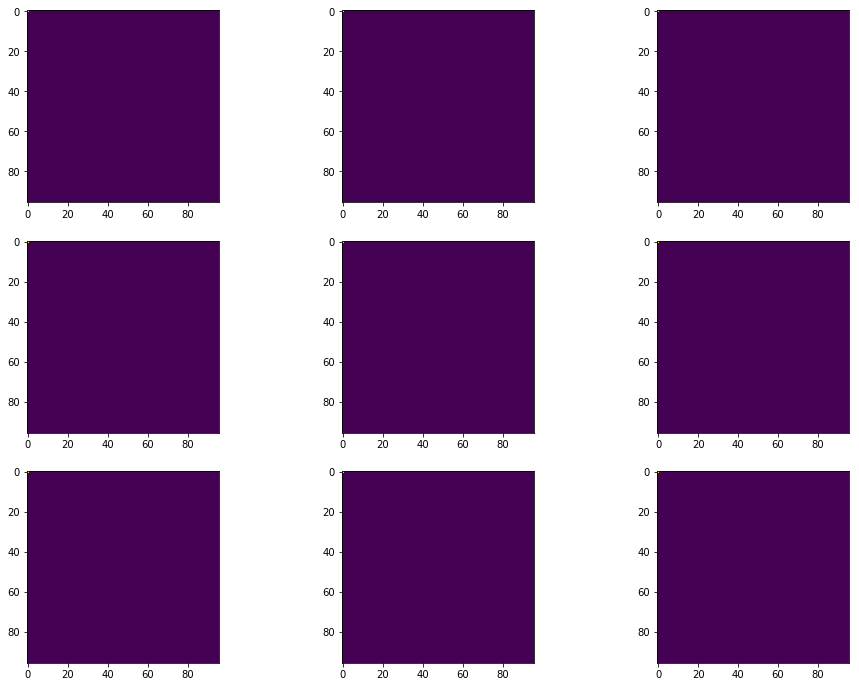

In [54]:
fig = plt.figure(figsize=(16,12))

for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    plt.grid(False)
    preds[i][0][0,0]=3
    plt.imshow(preds[i][0])